# Multi‑Horizon Forecast Comparison (H1, D1, W1, M1)

*Appended automatically on 2025-10-08 19:44 UTC.*

This section compares **four different time‑horizon predictions** found in the CSV:

- `y_hat_H1` — short horizon (e.g., next step / hour)
- `y_hat_D1` — daily horizon
- `y_hat_W1` — weekly horizon
- `y_hat_M1` — monthly horizon

It computes common error metrics per **model × horizon** and visualizes them.


In [1]:
# ==== Configuration ====
# Set the path to your CSV file here. If left as None, a small in-memory demo is used.
csv_path = None  # e.g., '/mnt/data/your_predictions.csv'

# Columns expected in the CSV:
# ts, model, v, y, y_hat_H1, y_hat_D1, y_hat_W1, y_hat_M1, pi


In [2]:
# ==== Imports ====
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple

# Display settings
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)


In [3]:
# ==== Load Data ====
from io import StringIO

if csv_path is None:
    demo_csv = StringIO("""ts,model,v,y,y_hat_H1,y_hat_D1,y_hat_W1,y_hat_M1,pi
2020-02-14T12:00:00,lag_adapter,8.41154804229737,1312.77902832031,956.1858763868765,877.478747242494,1343.364147246193,473.18349406401177,
2020-02-14T12:10:00,lag_adapter,8.94811565876007,1563.40854492188,1211.7134553682765,661.0247264533829,1174.8725162788635,632.8199656171491,
""")
    df = pd.read_csv(demo_csv)
else:
    df = pd.read_csv(csv_path)

# Parse timestamps if present
if "ts" in df.columns:
    df["ts"] = pd.to_datetime(df["ts"], errors="coerce")

# Basic sanity check
required_cols = {"model","y","y_hat_H1","y_hat_D1","y_hat_W1","y_hat_M1"}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

df.head()


,ts,model,v,y,y_hat_H1,y_hat_D1,y_hat_W1,y_hat_M1,pi
0,2020-02-14 12:00:00,lag_adapter,8.411548,1312.779028,956.185876,877.478747,1343.364147,473.183494,NaN
1,2020-02-14 12:10:00,lag_adapter,8.948116,1563.408545,1211.713455,661.024726,1174.872516,632.819966,NaN


In [4]:
# ==== Compute Metrics Per Model × Horizon ====

# Melt horizons into long format
h_cols = ["y_hat_H1", "y_hat_D1", "y_hat_W1", "y_hat_M1"]
long = df.melt(
    id_vars=[c for c in df.columns if c not in h_cols],
    value_vars=h_cols,
    var_name="horizon",
    value_name="y_hat",
)

# Normalize horizon labels like H1, D1, W1, M1
long["horizon"] = long["horizon"].str.replace("y_hat_", "", regex=False)

def safe_mape(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    eps = 1e-9
    denom = np.where(np.abs(y_true) < eps, np.nan, np.abs(y_true))
    return np.nanmean(np.abs((y_true - y_pred) / denom)) * 100.0

def compute_metrics(group: pd.DataFrame) -> Dict[str, float]:
    y = group["y"].astype(float).to_numpy()
    yhat = group["y_hat"].astype(float).to_numpy()
    resid = y - yhat
    mae = float(np.mean(np.abs(resid)))
    rmse = float(np.sqrt(np.mean(resid**2)))
    mape = float(safe_mape(y, yhat))
    # R^2
    ss_res = float(np.sum(resid**2))
    ss_tot = float(np.sum((y - np.mean(y))**2)) if len(y) > 1 else np.nan
    r2 = 1.0 - ss_res/ss_tot if ss_tot and not math.isclose(ss_tot, 0.0) else np.nan
    return {"MAE": mae, "RMSE": rmse, "MAPE_%": mape, "R2": r2}

metrics = (
    long
    .dropna(subset=["y","y_hat"])
    .groupby(["model","horizon"], as_index=False)
    .apply(lambda g: pd.Series(compute_metrics(g)))
    .sort_values(["model","horizon"])
    .reset_index(drop=True)
)

metrics


C:\Users\gebruiker\AppData\Local\Temp\ipykernel_34176\3017202430.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(compute_metrics(g)))


,model,horizon,MAE,RMSE,MAPE_%,R2
0,lag_adapter,D1,668.842050,708.442972,45.438844,-30.959896
1,lag_adapter,H1,354.144121,354.152589,24.829316,-6.986866
2,lag_adapter,M1,885.092057,886.260618,61.739323,-49.017095
3,lag_adapter,W1,209.560574,275.586370,13.590827,-3.836275


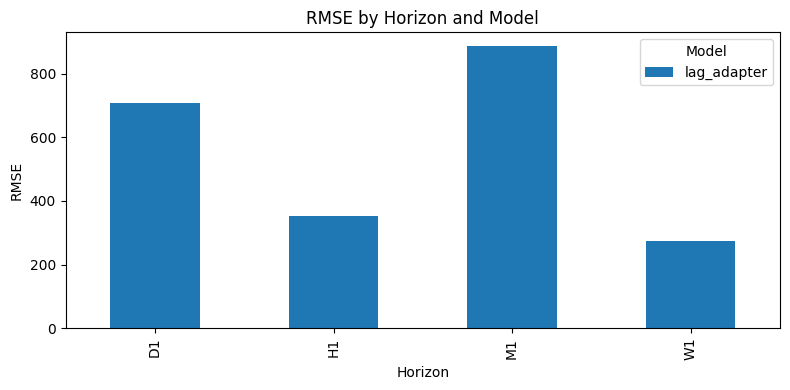

In [5]:
# ==== Plot RMSE by Horizon (Grouped by Model) ====
# One figure: x=horizon, grouped bars by model

pivot_rmse = metrics.pivot(index="horizon", columns="model", values="RMSE")
ax = pivot_rmse.plot(kind="bar", figsize=(8,4))
ax.set_title("RMSE by Horizon and Model")
ax.set_xlabel("Horizon")
ax.set_ylabel("RMSE")
ax.legend(title="Model")
plt.tight_layout()
plt.show()


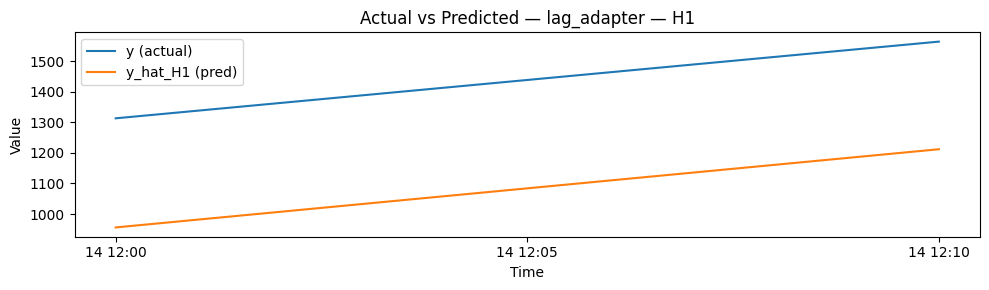

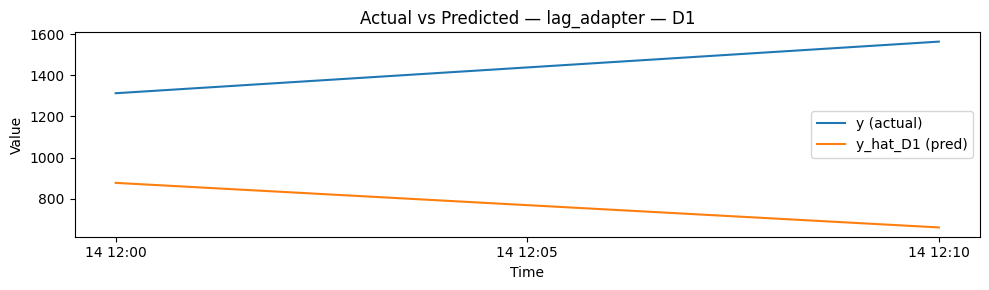

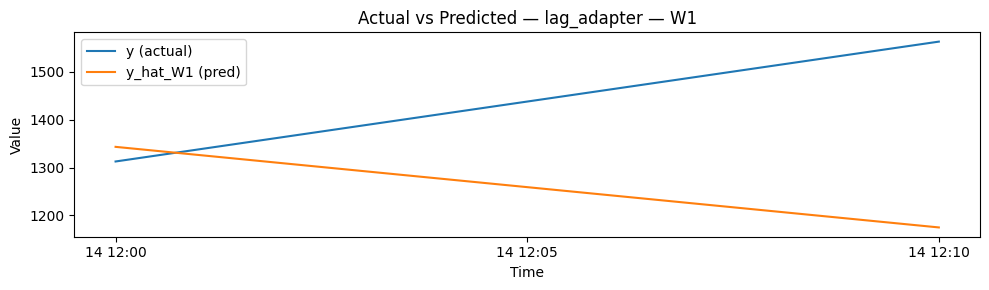

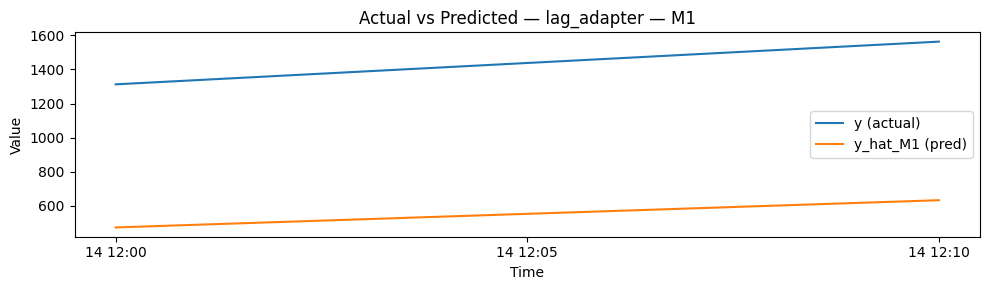

In [6]:
# ==== Example Time Series Plots: Actual vs Predicted (Per Horizon) ====
# This produces four separate plots (one per horizon)
# If you have many points, consider slicing with a date range or tail().

for hz in ["H1","D1","W1","M1"]:
    col = f"y_hat_{hz}"
    if col not in df.columns:
        continue

    # Use one model at a time if multiple exist (or plot all predictions together if desired).
    # Here, we'll plot the first model's series to keep the plot uncluttered.
    first_model = df["model"].iloc[0]
    sub = df[df["model"] == first_model].copy()

    # If timestamps exist, sort by ts for a proper line chart
    if "ts" in sub.columns:
        sub = sub.sort_values("ts")

    plt.figure(figsize=(10,3))
    if "ts" in sub.columns and pd.api.types.is_datetime64_any_dtype(sub["ts"]):
        x = sub["ts"]
    else:
        x = np.arange(len(sub))

    plt.plot(x, sub["y"], label="y (actual)")
    plt.plot(x, sub[col], label=f"{col} (pred)")
    plt.title(f"Actual vs Predicted — {first_model} — {hz}")
    plt.xlabel("Time" if "ts" in sub.columns else "Index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


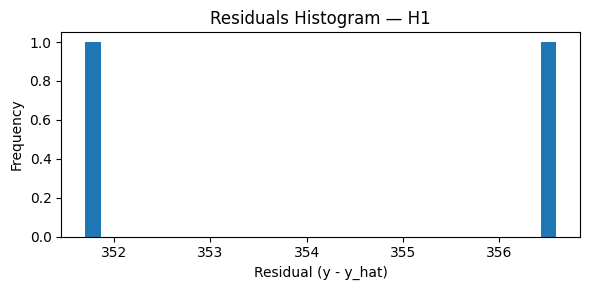

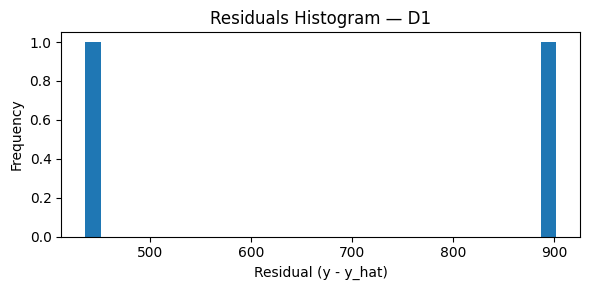

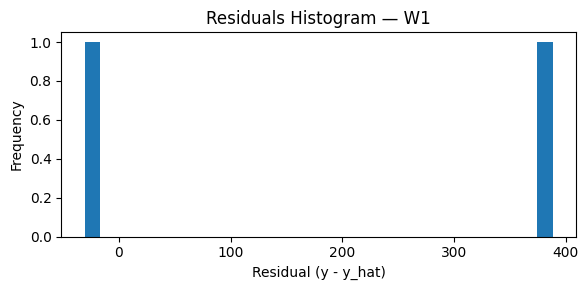

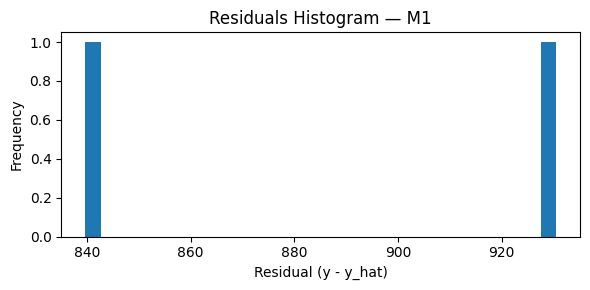

In [7]:
# ==== Residual Distribution by Horizon (All Models Combined) ====
import numpy as np

for hz in ["H1","D1","W1","M1"]:
    hz_long = long[long["horizon"] == hz].dropna(subset=["y","y_hat"])
    if hz_long.empty:
        continue
    resid = (hz_long["y"] - hz_long["y_hat"]).astype(float).to_numpy()
    plt.figure(figsize=(6,3))
    plt.hist(resid, bins=30)
    plt.title(f"Residuals Histogram — {hz}")
    plt.xlabel("Residual (y - y_hat)")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


### Notes
- **MAPE** excludes points where `|y| < 1e-9` to avoid division-by-zero.
- If you want **per-horizon leaderboards**, sort `metrics` within each horizon by RMSE or MAE.
- To focus on a specific **date window**, filter `df` by `ts` before melting.
- If you have **prediction intervals** (`pi`), you can extend this section with coverage and sharpness metrics.
